# Multi-Class Classifier Benchmark

## Load data

In [1]:
import pandas as pd

input_path = '../Data/Intermediate_Files/'
output_path = '../Data/Processed_Data/'

# read df_discovery and df_validation
df_discovery = pd.read_pickle(
    input_path+'df_discovery.pkl').sort_index()

df_validation = pd.read_pickle(
    input_path+'df_validation.pkl').sort_index()

# Load clinical data
discovery_clinical_data = pd.read_csv(input_path+'discovery_clinical_data.csv',
                                      low_memory=False, index_col=0)

validation_clinical_data = pd.read_csv(input_path+'validation_clinical_data.csv',
                                        low_memory=False, index_col=0)

In [1]:
import pandas as pd
output_path = '../Data/Processed_Data/'
df = pd.read_csv(output_path+'pacmap_output/pacmap_2d_output_acute_leukemia.csv', index_col=0)

## Preprocess data

### Exclude categories with <10 samples

In [2]:
# exclude the samples with mixed phenotypes and Down syndrome and t(9;22)(q34.1;q11.2)/BCR::ABL1
df = df[~df['ELN AML 2022 Diagnosis'].isin(['Mixed phenotype acute leukemia T/myeloid',
                                       'Myeloid leukaemia associated with Down syndrome',
                                       'AML with t(9;22)(q34.1;q11.2)/BCR::ABL1'])]

In [3]:
df['ELN AML 2022 Diagnosis'].value_counts()

ELN AML 2022 Diagnosis
AML with t(9;11)(p22;q23.3)/KMT2A-rearrangement                           313
AML with inv(16)(p13.1q22) or t(16;16)(p13.1;q22)/CBFB::MYH11             178
AML with mutated NPM1                                                     172
AML with t(8;21)(q22;q22.1)/RUNX1::RUNX1T1                                169
AML with other rare recurring translocations                              162
MDS-related or secondary myeloid neoplasms                                148
Otherwise-Normal Control                                                  121
AML with in-frame bZIP mutated CEBPA                                       69
APL with t(15;17)(q24.1;q21.2)/PML::RARA                                   31
AML with t(6;9)(p23;q34.1)/DEK::NUP214                                     26
AML with inv(3)(q21.3q26.2) or t(3;3)(q21.3;q26.2)/MECOM-rearrangement     10
Name: count, dtype: int64

### Exclude samples with missing labels

In [4]:
# drop the samples with missing labels for the ELN AML 2022 Diagnosis
df = df[~df['ELN AML 2022 Diagnosis'].isna()]

### Define X and y

In [5]:

# Define X and y
X = df[['PaCMAP 1', 'PaCMAP 2']].to_numpy()
y = df['ELN AML 2022 Diagnosis'].to_numpy()

In [2]:
df = pd.read_csv(output_path+'pacmap_output/pacmap_10d_output_acute_leukemia.csv', index_col=0)
# exclude the samples with mixed phenotypes and Down syndrome and t(9;22)(q34.1;q11.2)/BCR::ABL1
df3 = df[~df['ELN AML 2022 Diagnosis'].isin(['Mixed phenotype acute leukemia T/myeloid',
                                       'Myeloid leukaemia associated with Down syndrome',
                                       'AML with t(9;22)(q34.1;q11.2)/BCR::ABL1'])]

# drop the samples with missing labels for the ELN AML 2022 Diagnosis
df3 = df3[~df3['ELN AML 2022 Diagnosis'].isna()]

# Define X and y
X = df3[['PaCMAP 1', 'PaCMAP 2','PaCMAP 3','PaCMAP 4','PaCMAP 5',
         'PaCMAP 6', 'PaCMAP 7','PaCMAP 8','PaCMAP 9','PaCMAP 10']].to_numpy() # shape (n_samples=1399, n_features=2)
y = df3['ELN AML 2022 Diagnosis'].to_numpy() # shape (n_samples=1399,) with 11 string classes

In [3]:
# One hot encode the labels
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

## Define model architecture

[2 inputs] -> [8 hidden neurons] -> [11 outputs]

In [5]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


# convert pandas DataFrame (X) and numpy array (y) into PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

class Multiclass(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(10, 20)
        self.act = nn.ReLU()
        self.output = nn.Linear(20, 11)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x

# loss metric and optimizer
model = Multiclass()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# prepare model and training parameters
n_epochs = 100
batch_size = 5
batches_per_epoch = len(X_train) // batch_size

best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test)
    ce = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")

# Restore best model
model.load_state_dict(best_weights)

/tmp/ipykernel_6886/4151555880.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_6886/4151555880.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
Epoch 0: 100%|██████████| 195/195 [00:00<00:00, 318.38batch/s, acc=0.8, loss=0.915]


Epoch 0 validation: Cross-entropy=1.13, Accuracy=66.2%


Epoch 1: 100%|██████████| 195/195 [00:00<00:00, 497.00batch/s, acc=0.8, loss=0.707]


Epoch 1 validation: Cross-entropy=0.97, Accuracy=72.9%


Epoch 2: 100%|██████████| 195/195 [00:00<00:00, 532.09batch/s, acc=0.8, loss=0.672]


Epoch 2 validation: Cross-entropy=0.92, Accuracy=74.8%


Epoch 3: 100%|██████████| 195/195 [00:00<00:00, 495.69batch/s, acc=0.8, loss=0.659]


Epoch 3 validation: Cross-entropy=0.89, Accuracy=76.7%


Epoch 4: 100%|██████████| 195/195 [00:00<00:00, 547.20batch/s, acc=0.8, loss=0.649]


Epoch 4 validation: Cross-entropy=0.87, Accuracy=77.1%


Epoch 5: 100%|██████████| 195/195 [00:00<00:00, 527.51batch/s, acc=0.8, loss=0.642]


Epoch 5 validation: Cross-entropy=0.86, Accuracy=77.1%


Epoch 6: 100%|██████████| 195/195 [00:00<00:00, 540.19batch/s, acc=0.8, loss=0.636]


Epoch 6 validation: Cross-entropy=0.86, Accuracy=77.1%


Epoch 7: 100%|██████████| 195/195 [00:00<00:00, 521.81batch/s, acc=0.8, loss=0.632]


Epoch 7 validation: Cross-entropy=0.85, Accuracy=77.6%


Epoch 8: 100%|██████████| 195/195 [00:00<00:00, 521.07batch/s, acc=0.8, loss=0.629]


Epoch 8 validation: Cross-entropy=0.85, Accuracy=77.9%


Epoch 9: 100%|██████████| 195/195 [00:00<00:00, 482.79batch/s, acc=0.8, loss=0.623]


Epoch 9 validation: Cross-entropy=0.84, Accuracy=77.9%


Epoch 10: 100%|██████████| 195/195 [00:00<00:00, 519.75batch/s, acc=0.8, loss=0.622]


Epoch 10 validation: Cross-entropy=0.84, Accuracy=77.9%


Epoch 11: 100%|██████████| 195/195 [00:00<00:00, 493.92batch/s, acc=0.8, loss=0.617]


Epoch 11 validation: Cross-entropy=0.84, Accuracy=77.9%


Epoch 12: 100%|██████████| 195/195 [00:00<00:00, 528.13batch/s, acc=0.8, loss=0.616]


Epoch 12 validation: Cross-entropy=0.84, Accuracy=78.1%


Epoch 13: 100%|██████████| 195/195 [00:00<00:00, 506.74batch/s, acc=0.8, loss=0.612]


Epoch 13 validation: Cross-entropy=0.84, Accuracy=78.1%


Epoch 14: 100%|██████████| 195/195 [00:00<00:00, 523.36batch/s, acc=0.8, loss=0.61] 


Epoch 14 validation: Cross-entropy=0.84, Accuracy=78.6%


Epoch 15: 100%|██████████| 195/195 [00:00<00:00, 478.52batch/s, acc=0.8, loss=0.608]


Epoch 15 validation: Cross-entropy=0.83, Accuracy=78.8%


Epoch 16: 100%|██████████| 195/195 [00:00<00:00, 506.42batch/s, acc=0.8, loss=0.605]


Epoch 16 validation: Cross-entropy=0.83, Accuracy=79.0%


Epoch 17: 100%|██████████| 195/195 [00:00<00:00, 511.10batch/s, acc=0.8, loss=0.603]


Epoch 17 validation: Cross-entropy=0.83, Accuracy=79.3%


Epoch 18: 100%|██████████| 195/195 [00:00<00:00, 512.51batch/s, acc=0.8, loss=0.6]  


Epoch 18 validation: Cross-entropy=0.83, Accuracy=79.3%


Epoch 19: 100%|██████████| 195/195 [00:00<00:00, 503.79batch/s, acc=0.8, loss=0.598]


Epoch 19 validation: Cross-entropy=0.83, Accuracy=79.5%


Epoch 20: 100%|██████████| 195/195 [00:00<00:00, 497.47batch/s, acc=0.8, loss=0.598]


Epoch 20 validation: Cross-entropy=0.83, Accuracy=79.5%


Epoch 21: 100%|██████████| 195/195 [00:00<00:00, 541.67batch/s, acc=0.8, loss=0.592]


Epoch 21 validation: Cross-entropy=0.83, Accuracy=79.3%


Epoch 22: 100%|██████████| 195/195 [00:00<00:00, 499.72batch/s, acc=0.8, loss=0.603]


Epoch 22 validation: Cross-entropy=0.83, Accuracy=79.3%


Epoch 23: 100%|██████████| 195/195 [00:00<00:00, 544.14batch/s, acc=0.8, loss=0.598]


Epoch 23 validation: Cross-entropy=0.82, Accuracy=79.3%


Epoch 24: 100%|██████████| 195/195 [00:00<00:00, 481.43batch/s, acc=0.8, loss=0.606]


Epoch 24 validation: Cross-entropy=0.82, Accuracy=79.3%


Epoch 25: 100%|██████████| 195/195 [00:00<00:00, 494.55batch/s, acc=0.8, loss=0.6]  


Epoch 25 validation: Cross-entropy=0.82, Accuracy=79.3%


Epoch 26: 100%|██████████| 195/195 [00:00<00:00, 457.02batch/s, acc=0.8, loss=0.605]


Epoch 26 validation: Cross-entropy=0.82, Accuracy=79.3%


Epoch 27: 100%|██████████| 195/195 [00:00<00:00, 487.13batch/s, acc=0.8, loss=0.602]


Epoch 27 validation: Cross-entropy=0.83, Accuracy=79.3%


Epoch 28: 100%|██████████| 195/195 [00:00<00:00, 467.39batch/s, acc=0.8, loss=0.603]


Epoch 28 validation: Cross-entropy=0.83, Accuracy=79.3%


Epoch 29: 100%|██████████| 195/195 [00:00<00:00, 454.87batch/s, acc=0.8, loss=0.603]


Epoch 29 validation: Cross-entropy=0.83, Accuracy=79.3%


Epoch 30: 100%|██████████| 195/195 [00:00<00:00, 442.10batch/s, acc=0.8, loss=0.603]


Epoch 30 validation: Cross-entropy=0.83, Accuracy=79.3%


Epoch 31: 100%|██████████| 195/195 [00:00<00:00, 505.11batch/s, acc=0.8, loss=0.603]


Epoch 31 validation: Cross-entropy=0.83, Accuracy=79.3%


Epoch 32: 100%|██████████| 195/195 [00:00<00:00, 470.14batch/s, acc=0.8, loss=0.602]


Epoch 32 validation: Cross-entropy=0.83, Accuracy=79.3%


Epoch 33: 100%|██████████| 195/195 [00:00<00:00, 485.98batch/s, acc=0.8, loss=0.6]  


Epoch 33 validation: Cross-entropy=0.83, Accuracy=79.5%


Epoch 34: 100%|██████████| 195/195 [00:00<00:00, 462.88batch/s, acc=0.8, loss=0.599]


Epoch 34 validation: Cross-entropy=0.83, Accuracy=79.5%


Epoch 35: 100%|██████████| 195/195 [00:00<00:00, 471.74batch/s, acc=0.8, loss=0.594]


Epoch 35 validation: Cross-entropy=0.83, Accuracy=79.5%


Epoch 36: 100%|██████████| 195/195 [00:00<00:00, 474.46batch/s, acc=0.8, loss=0.597]


Epoch 36 validation: Cross-entropy=0.83, Accuracy=79.5%


Epoch 37: 100%|██████████| 195/195 [00:00<00:00, 490.49batch/s, acc=0.8, loss=0.593]


Epoch 37 validation: Cross-entropy=0.83, Accuracy=79.5%


Epoch 38: 100%|██████████| 195/195 [00:00<00:00, 473.78batch/s, acc=0.8, loss=0.594]


Epoch 38 validation: Cross-entropy=0.83, Accuracy=79.5%


Epoch 39: 100%|██████████| 195/195 [00:00<00:00, 473.11batch/s, acc=0.8, loss=0.589]


Epoch 39 validation: Cross-entropy=0.83, Accuracy=79.5%


Epoch 40: 100%|██████████| 195/195 [00:00<00:00, 477.38batch/s, acc=0.8, loss=0.592]


Epoch 40 validation: Cross-entropy=0.83, Accuracy=79.8%


Epoch 41: 100%|██████████| 195/195 [00:00<00:00, 456.12batch/s, acc=0.8, loss=0.589]


Epoch 41 validation: Cross-entropy=0.83, Accuracy=79.5%


Epoch 42: 100%|██████████| 195/195 [00:00<00:00, 486.73batch/s, acc=0.8, loss=0.585]


Epoch 42 validation: Cross-entropy=0.84, Accuracy=79.8%


Epoch 43: 100%|██████████| 195/195 [00:00<00:00, 471.57batch/s, acc=0.8, loss=0.584]


Epoch 43 validation: Cross-entropy=0.84, Accuracy=79.8%


Epoch 44: 100%|██████████| 195/195 [00:00<00:00, 480.81batch/s, acc=0.8, loss=0.583]


Epoch 44 validation: Cross-entropy=0.84, Accuracy=79.5%


Epoch 45: 100%|██████████| 195/195 [00:00<00:00, 447.90batch/s, acc=0.8, loss=0.585]


Epoch 45 validation: Cross-entropy=0.84, Accuracy=79.8%


Epoch 46: 100%|██████████| 195/195 [00:00<00:00, 514.76batch/s, acc=0.8, loss=0.579]


Epoch 46 validation: Cross-entropy=0.84, Accuracy=79.8%


Epoch 47: 100%|██████████| 195/195 [00:00<00:00, 515.63batch/s, acc=0.6, loss=0.583]


Epoch 47 validation: Cross-entropy=0.84, Accuracy=79.8%


Epoch 48: 100%|██████████| 195/195 [00:00<00:00, 522.41batch/s, acc=0.8, loss=0.577]


Epoch 48 validation: Cross-entropy=0.84, Accuracy=79.8%


Epoch 49: 100%|██████████| 195/195 [00:00<00:00, 483.77batch/s, acc=0.6, loss=0.581]


Epoch 49 validation: Cross-entropy=0.84, Accuracy=79.8%


Epoch 50: 100%|██████████| 195/195 [00:00<00:00, 538.69batch/s, acc=0.6, loss=0.579]


Epoch 50 validation: Cross-entropy=0.85, Accuracy=79.8%


Epoch 51: 100%|██████████| 195/195 [00:00<00:00, 511.38batch/s, acc=0.6, loss=0.579]


Epoch 51 validation: Cross-entropy=0.85, Accuracy=79.8%


Epoch 52: 100%|██████████| 195/195 [00:00<00:00, 526.38batch/s, acc=0.6, loss=0.58] 


Epoch 52 validation: Cross-entropy=0.85, Accuracy=79.8%


Epoch 53: 100%|██████████| 195/195 [00:00<00:00, 487.65batch/s, acc=0.6, loss=0.58] 


Epoch 53 validation: Cross-entropy=0.85, Accuracy=79.8%


Epoch 54: 100%|██████████| 195/195 [00:00<00:00, 530.09batch/s, acc=0.6, loss=0.575]


Epoch 54 validation: Cross-entropy=0.85, Accuracy=79.8%


Epoch 55: 100%|██████████| 195/195 [00:00<00:00, 529.45batch/s, acc=0.6, loss=0.575]


Epoch 55 validation: Cross-entropy=0.86, Accuracy=79.8%


Epoch 56: 100%|██████████| 195/195 [00:00<00:00, 501.54batch/s, acc=0.6, loss=0.574]


Epoch 56 validation: Cross-entropy=0.86, Accuracy=79.8%


Epoch 57: 100%|██████████| 195/195 [00:00<00:00, 493.32batch/s, acc=0.6, loss=0.575]


Epoch 57 validation: Cross-entropy=0.86, Accuracy=79.8%


Epoch 58: 100%|██████████| 195/195 [00:00<00:00, 503.65batch/s, acc=0.6, loss=0.576]


Epoch 58 validation: Cross-entropy=0.86, Accuracy=79.5%


Epoch 59: 100%|██████████| 195/195 [00:00<00:00, 532.77batch/s, acc=0.6, loss=0.573]


Epoch 59 validation: Cross-entropy=0.86, Accuracy=79.8%


Epoch 60: 100%|██████████| 195/195 [00:00<00:00, 519.15batch/s, acc=0.6, loss=0.573]


Epoch 60 validation: Cross-entropy=0.86, Accuracy=79.8%


Epoch 61: 100%|██████████| 195/195 [00:00<00:00, 540.17batch/s, acc=0.6, loss=0.579]


Epoch 61 validation: Cross-entropy=0.87, Accuracy=79.5%


Epoch 62: 100%|██████████| 195/195 [00:00<00:00, 493.72batch/s, acc=0.6, loss=0.575]


Epoch 62 validation: Cross-entropy=0.87, Accuracy=79.8%


Epoch 63: 100%|██████████| 195/195 [00:00<00:00, 531.51batch/s, acc=0.6, loss=0.577]


Epoch 63 validation: Cross-entropy=0.87, Accuracy=79.8%


Epoch 64: 100%|██████████| 195/195 [00:00<00:00, 508.93batch/s, acc=0.6, loss=0.583]


Epoch 64 validation: Cross-entropy=0.87, Accuracy=79.5%


Epoch 65: 100%|██████████| 195/195 [00:00<00:00, 520.47batch/s, acc=0.6, loss=0.577]


Epoch 65 validation: Cross-entropy=0.87, Accuracy=79.8%


Epoch 66: 100%|██████████| 195/195 [00:00<00:00, 491.15batch/s, acc=0.6, loss=0.578]


Epoch 66 validation: Cross-entropy=0.87, Accuracy=79.5%


Epoch 67: 100%|██████████| 195/195 [00:00<00:00, 535.95batch/s, acc=0.6, loss=0.581]


Epoch 67 validation: Cross-entropy=0.88, Accuracy=79.5%


Epoch 68: 100%|██████████| 195/195 [00:00<00:00, 523.09batch/s, acc=0.6, loss=0.578]


Epoch 68 validation: Cross-entropy=0.88, Accuracy=79.5%


Epoch 69: 100%|██████████| 195/195 [00:00<00:00, 534.17batch/s, acc=0.6, loss=0.58] 


Epoch 69 validation: Cross-entropy=0.88, Accuracy=79.3%


Epoch 70: 100%|██████████| 195/195 [00:00<00:00, 520.39batch/s, acc=0.6, loss=0.579]


Epoch 70 validation: Cross-entropy=0.88, Accuracy=79.5%


Epoch 71: 100%|██████████| 195/195 [00:00<00:00, 494.60batch/s, acc=0.6, loss=0.579]


Epoch 71 validation: Cross-entropy=0.88, Accuracy=79.5%


Epoch 72: 100%|██████████| 195/195 [00:00<00:00, 505.63batch/s, acc=0.6, loss=0.584]


Epoch 72 validation: Cross-entropy=0.89, Accuracy=79.5%


Epoch 73: 100%|██████████| 195/195 [00:00<00:00, 531.46batch/s, acc=0.6, loss=0.581]


Epoch 73 validation: Cross-entropy=0.89, Accuracy=79.5%


Epoch 74: 100%|██████████| 195/195 [00:00<00:00, 511.68batch/s, acc=0.6, loss=0.582]


Epoch 74 validation: Cross-entropy=0.89, Accuracy=79.5%


Epoch 75: 100%|██████████| 195/195 [00:00<00:00, 483.02batch/s, acc=0.6, loss=0.583]


Epoch 75 validation: Cross-entropy=0.90, Accuracy=79.3%


Epoch 76: 100%|██████████| 195/195 [00:00<00:00, 520.45batch/s, acc=0.6, loss=0.587]


Epoch 76 validation: Cross-entropy=0.90, Accuracy=79.5%


Epoch 77: 100%|██████████| 195/195 [00:00<00:00, 542.04batch/s, acc=0.6, loss=0.583]


Epoch 77 validation: Cross-entropy=0.90, Accuracy=79.5%


Epoch 78: 100%|██████████| 195/195 [00:00<00:00, 545.55batch/s, acc=0.6, loss=0.581]


Epoch 78 validation: Cross-entropy=0.90, Accuracy=79.5%


Epoch 79: 100%|██████████| 195/195 [00:00<00:00, 535.54batch/s, acc=0.6, loss=0.586]


Epoch 79 validation: Cross-entropy=0.90, Accuracy=79.8%


Epoch 80: 100%|██████████| 195/195 [00:00<00:00, 492.70batch/s, acc=0.6, loss=0.585]


Epoch 80 validation: Cross-entropy=0.91, Accuracy=79.8%


Epoch 81: 100%|██████████| 195/195 [00:00<00:00, 535.22batch/s, acc=0.6, loss=0.59] 


Epoch 81 validation: Cross-entropy=0.91, Accuracy=79.8%


Epoch 82: 100%|██████████| 195/195 [00:00<00:00, 517.97batch/s, acc=0.6, loss=0.588]


Epoch 82 validation: Cross-entropy=0.91, Accuracy=79.8%


Epoch 83: 100%|██████████| 195/195 [00:00<00:00, 519.05batch/s, acc=0.6, loss=0.592]


Epoch 83 validation: Cross-entropy=0.91, Accuracy=79.8%


Epoch 84: 100%|██████████| 195/195 [00:00<00:00, 486.75batch/s, acc=0.6, loss=0.588]


Epoch 84 validation: Cross-entropy=0.91, Accuracy=79.8%


Epoch 85: 100%|██████████| 195/195 [00:00<00:00, 535.42batch/s, acc=0.6, loss=0.591]


Epoch 85 validation: Cross-entropy=0.92, Accuracy=79.8%


Epoch 86: 100%|██████████| 195/195 [00:00<00:00, 517.49batch/s, acc=0.6, loss=0.595]


Epoch 86 validation: Cross-entropy=0.92, Accuracy=79.8%


Epoch 87: 100%|██████████| 195/195 [00:00<00:00, 526.81batch/s, acc=0.6, loss=0.593]


Epoch 87 validation: Cross-entropy=0.92, Accuracy=79.8%


Epoch 88: 100%|██████████| 195/195 [00:00<00:00, 513.70batch/s, acc=0.6, loss=0.596]


Epoch 88 validation: Cross-entropy=0.93, Accuracy=79.8%


Epoch 89: 100%|██████████| 195/195 [00:00<00:00, 506.23batch/s, acc=0.6, loss=0.592]


Epoch 89 validation: Cross-entropy=0.93, Accuracy=79.8%


Epoch 90: 100%|██████████| 195/195 [00:00<00:00, 499.25batch/s, acc=0.6, loss=0.599]


Epoch 90 validation: Cross-entropy=0.93, Accuracy=79.8%


Epoch 91: 100%|██████████| 195/195 [00:00<00:00, 526.72batch/s, acc=0.6, loss=0.595]


Epoch 91 validation: Cross-entropy=0.93, Accuracy=79.8%


Epoch 92: 100%|██████████| 195/195 [00:00<00:00, 505.66batch/s, acc=0.6, loss=0.597]


Epoch 92 validation: Cross-entropy=0.94, Accuracy=79.8%


Epoch 93: 100%|██████████| 195/195 [00:00<00:00, 531.24batch/s, acc=0.6, loss=0.594]


Epoch 93 validation: Cross-entropy=0.93, Accuracy=79.8%


Epoch 94: 100%|██████████| 195/195 [00:00<00:00, 495.77batch/s, acc=0.6, loss=0.604]


Epoch 94 validation: Cross-entropy=0.94, Accuracy=79.8%


Epoch 95: 100%|██████████| 195/195 [00:00<00:00, 521.02batch/s, acc=0.6, loss=0.597]


Epoch 95 validation: Cross-entropy=0.94, Accuracy=79.8%


Epoch 96: 100%|██████████| 195/195 [00:00<00:00, 511.58batch/s, acc=0.6, loss=0.599]


Epoch 96 validation: Cross-entropy=0.95, Accuracy=79.8%


Epoch 97: 100%|██████████| 195/195 [00:00<00:00, 528.50batch/s, acc=0.6, loss=0.598]


Epoch 97 validation: Cross-entropy=0.94, Accuracy=79.8%


Epoch 98: 100%|██████████| 195/195 [00:00<00:00, 500.35batch/s, acc=0.6, loss=0.604]


Epoch 98 validation: Cross-entropy=0.95, Accuracy=79.8%


Epoch 99: 100%|██████████| 195/195 [00:00<00:00, 529.32batch/s, acc=0.6, loss=0.599]


Epoch 99 validation: Cross-entropy=0.95, Accuracy=79.8%


<All keys matched successfully>

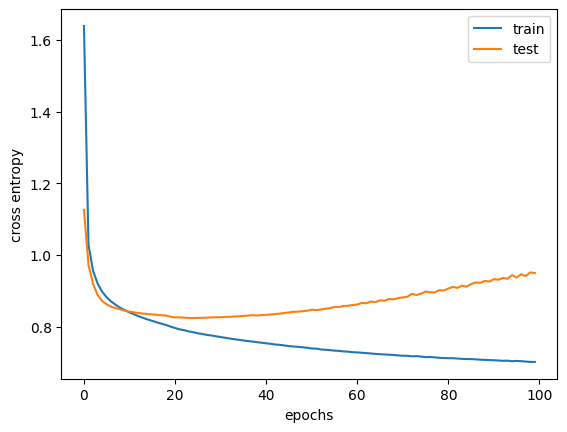

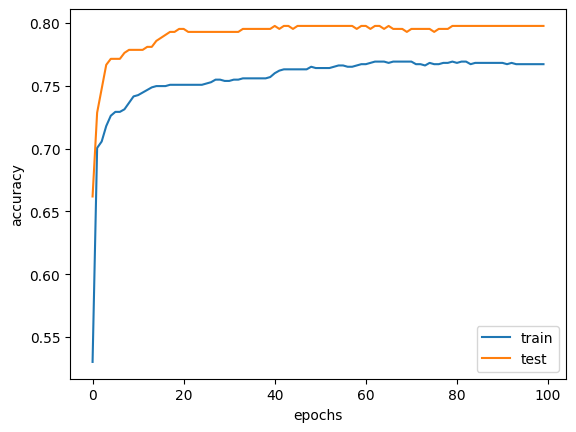

In [7]:

# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

## Confusion Matrix

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, X_test, y_test, label_encoder):
    sns.set_theme(style='white')

    # Make sure the model is in evaluation mode
    model.eval()

    # Compute the model predictions
    with torch.no_grad():
        y_pred = model(X_test)
        y_pred = torch.argmax(y_pred, 1)

    # Convert tensors to NumPy arrays for use with sklearn
    y_pred = y_pred.cpu().numpy()
    y_test = y_test.cpu().numpy()

    cm = confusion_matrix(y_test, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=label_encoder.classes_)
    disp.plot(cmap='Blues', values_format='.2f', xticks_rotation='vertical')

    # Increase the size of the plot
    fig = plt.gcf()
    fig.set_size_inches(10, 10)

    # Add title and axis names
    plt.title('Classification Results, n=' + str(len(X_test)), fontsize=14, fontweight='bold')
    plt.xlabel('Predicted', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=14, fontweight='bold')

    plt.show()

plot_confusion_matrix(model, X_test, y_test, label_encoder)


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets